In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


perform = pd.read_csv('./horse/data/perform_clean.csv', sep=',', encoding='utf-8')
perform['speed'] = perform['distance']/perform['finish_time']
perform['is_champ'] = perform['pla'].apply(lambda x: 1 if x==1 else 0)

y_cols = ['is_champ', 'pla', 'finish_time', 'speed']
date_cols = ['race_key', 'race_date']

get_x_cols = lambda x: [col for col in x if (col not in y_cols) and (col not in date_cols)]
x_cols = get_x_cols(perform.columns)

perform.head(5)

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time,speed
0,2015/04/22_1,2015/04/22,2,1000,好地至快地,草地,575000,120,1186,7.3,有情風(N139),薛寶力,吳定強,1,1,57.37,17.430713
1,2015/04/22_1,2015/04/22,3,1000,好地至快地,草地,575000,132,1022,6.1,樂趣(S150),韋達,霍利時,0,2,57.53,17.382235
2,2015/04/22_1,2015/04/22,5,1000,好地至快地,草地,575000,121,1085,48.0,穩佔先機(N359),連達文,苗禮德,0,3,57.78,17.307027
3,2015/04/22_1,2015/04/22,7,1000,好地至快地,草地,575000,127,1211,7.8,上浦勇將(P285),田泰安,徐雨石,0,4,57.82,17.295054
4,2015/04/22_1,2015/04/22,1,1000,好地至快地,草地,575000,124,1088,14.0,大地王者(L251),黎海榮,李易達,0,5,57.89,17.274141


## 2 Feature Process

### 2.1 Categorization

In [2]:
# low cardinality, encoding with 0/1
perform.course_type.unique() # '草地', '全天候跑道'; nunique=2
perform.course_type = perform.course_type.replace({'全天候跑道':0, '草地':1})

# high cardinality, encoding with embedding. 
#   Note: Emb value is in model, here only process with mapping index
def col2ix(df_col:pd.Series):
    """ Mapping from column's item to indecies.

        Returns:
            ix2item: dict
                with key as index, value is the hashed item
            item2ix: dict
                with key as item, value as its index
    """
    ix = list(range(df_col.nunique()))
    item = df_col.unique().tolist()

    return dict(zip(ix, item)), dict(zip(item, ix))

# mapping dict
ix2field, field2ix = col2ix(perform['field_going'])
ix2jockey, jockey2ix = col2ix(perform['jockey'])
ix2horse, horse2ix = col2ix(perform['horse'])
ix2trainer, trainer2ix = col2ix(perform['trainer'])

# perform after mapping
perform['field_going'] = perform['field_going'].apply(lambda x: field2ix[x])
perform['jockey'] = perform['jockey'].apply(lambda x: jockey2ix[x])
perform['horse'] = perform['horse'].apply(lambda x: horse2ix[x])
perform['trainer'] = perform['trainer'].apply(lambda x: trainer2ix[x])

perform.head(5)

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time,speed
0,2015/04/22_1,2015/04/22,2,1000,0,1,575000,120,1186,7.3,0,0,0,1,1,57.37,17.430713
1,2015/04/22_1,2015/04/22,3,1000,0,1,575000,132,1022,6.1,1,1,1,0,2,57.53,17.382235
2,2015/04/22_1,2015/04/22,5,1000,0,1,575000,121,1085,48.0,2,2,2,0,3,57.78,17.307027
3,2015/04/22_1,2015/04/22,7,1000,0,1,575000,127,1211,7.8,3,3,3,0,4,57.82,17.295054
4,2015/04/22_1,2015/04/22,1,1000,0,1,575000,124,1088,14.0,4,4,4,0,5,57.89,17.274141


### 2.2 Scaling

In [3]:
def zscore_standarlization(col):
    return (col-col.mean())/col.std()

perform['distance'] = zscore_standarlization(perform['distance'])
perform['race_money'] = zscore_standarlization(perform['race_money'])
perform['act_wt'] = zscore_standarlization(perform['act_wt'])
perform['declare_horse_wt'] = zscore_standarlization(perform['declare_horse_wt'])

perform.head()

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time,speed
0,2015/04/22_1,2015/04/22,2,-1.404898,0,1,-0.394974,-0.540745,1.080522,7.3,0,0,0,1,1,57.37,17.430713
1,2015/04/22_1,2015/04/22,3,-1.404898,0,1,-0.394974,1.432011,-1.417146,6.1,1,1,1,0,2,57.53,17.382235
2,2015/04/22_1,2015/04/22,5,-1.404898,0,1,-0.394974,-0.376349,-0.457676,48.0,2,2,2,0,3,57.78,17.307027
3,2015/04/22_1,2015/04/22,7,-1.404898,0,1,-0.394974,0.610030,1.461264,7.8,3,3,3,0,4,57.82,17.295054
4,2015/04/22_1,2015/04/22,1,-1.404898,0,1,-0.394974,0.116841,-0.411987,14.0,4,4,4,0,5,57.89,17.274141


<AxesSubplot:>

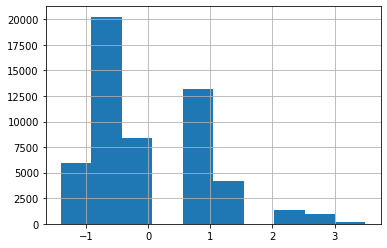

In [4]:
perform.distance.hist()

In [5]:
from horse.process import train_test_split

perform_train, perform_val, perform_test = train_test_split(perform, 'race_date', [0.8, 0.1, 0.1])

perform.shape, perform_train.shape, perform_val.shape, perform_test.shape

((54436, 17), (43157, 17), (5558, 17), (5721, 17))

In [1]:
from horse.data.load_data import DataSet

root = './horse/data/perform_clean.csv'
scaling = True

data = DataSet(root, scaling)
data.data

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time,speed,dr_ix
0,2015/04/22_1,2015/04/22,2,-1.404898,0,1,-0.394974,-0.540745,1.080522,7.3,0,0,0,1,1,57.37,17.430713,0
1,2015/04/22_1,2015/04/22,3,-1.404898,0,1,-0.394974,1.432011,-1.417146,6.1,1,1,1,0,2,57.53,17.382235,1
2,2015/04/22_1,2015/04/22,5,-1.404898,0,1,-0.394974,-0.376349,-0.457676,48.0,2,2,2,0,3,57.78,17.307027,2
3,2015/04/22_1,2015/04/22,7,-1.404898,0,1,-0.394974,0.610030,1.461264,7.8,3,3,3,0,4,57.82,17.295054,3
4,2015/04/22_1,2015/04/22,1,-1.404898,0,1,-0.394974,0.116841,-0.411987,14.0,4,4,4,0,5,57.89,17.274141,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54431,2023/01/18_8,2023/01/18,6,-1.404898,1,1,0.103894,-0.540745,-0.807959,35.0,4203,36,8,0,8,57.51,17.388280,5
54432,2023/01/18_8,2023/01/18,11,-1.404898,1,1,0.103894,-0.705141,1.628791,36.0,3364,21,3,0,9,57.66,17.343045,6
54433,2023/01/18_8,2023/01/18,3,-1.404898,1,1,0.103894,-0.376349,-0.640432,17.0,2870,12,12,0,10,57.78,17.307027,1
54434,2023/01/18_8,2023/01/18,8,-1.404898,1,1,0.103894,-0.869538,1.217589,144.0,4270,4,15,0,11,58.34,17.140898,7


In [3]:
train, val, test = data.train_val_test_spliting(perc=[0.7, 0.2, 0.1])

train.shape, val.shape, test.shape

((37530, 18), (11185, 18), (5721, 18))

## 3 Modeling

### 3.1 Assumption 1

Assume that all horses are independently racing at the court, with no affect regarding the number of race it is taking.

It is safe to treat it as a binary classification problem in this case, and apply the binary cross entropy as the loss function.

In [35]:
from torch import FloatTensor, LongTensor

y_col = ['is_champ']
numerical_cols = ['distance', 'course_type', 'race_money', 'act_wt', 'declare_horse_wt', 'dr']
categ_cols = ['field_going', 'horse', 'jockey', 'trainer']
x_cols = numerical_cols + categ_cols

def get_feats(data, numerical_cols, y_col, use_cuda=False):
    compute_device = device('cuda') if use_cuda else device('cpu')

    num = FloatTensor(data[numerical_cols].values).to(compute_device)
    d = LongTensor(data['dr_ix'].values).to(compute_device)
    f = LongTensor(data['field_going'].values).to(compute_device)
    j = LongTensor(data['jockey'].values).to(compute_device)
    h = LongTensor(data['horse'].values).to(compute_device)
    t = LongTensor(data['trainer'].values).to(compute_device)
    y = FloatTensor(data[y_col].values).to(compute_device)

    X = (num, d, f, j, h, t)
    return X, y

def horse_data_loader(X, y, batch_size, shuffle):
    from torch.utils.data import DataLoader

    return DataLoader(list(zip(*X, y)), batch_size=batch_size, shuffle=shuffle)

def create_data_batch(data, numerical_cols, y_col, batch_size, shuffle=True):
    X, y = get_feats(data, numerical_cols, y_col)

    return horse_data_loader(X, y, batch_size, shuffle)

dl = create_data_batch(perform_train, numerical_cols, y_col, 12)

In [42]:
from horse.process import racing_champ, AveragePrecision

def prep_eval_data(perform, use_cuda):
    """
    ((race_key, dr), (X, d, f, j, h, t))
    """
    keys = (perform[['race_key', 'dr']])
    X, y = get_feats(perform, numerical_cols, y_col, use_cuda)

    return keys, X

def computeAP(dataset, model, way='min', use_cuda=False):
    func = min if way=='min' else max
    ground_truth = racing_champ(dataset)
    result, X = prep_eval_data(dataset, use_cuda)
    score = model(*X)
    result['win'] = score.to(device('cpu')).detach().numpy()
    result = result.groupby(['race_key']) \
                .apply(lambda x: x[x['win']==func(x['win'])]) \
                .reset_index(drop=True)[['race_key', 'dr']]

    return AveragePrecision(result, ground_truth)

In [48]:
import torch.nn as nn
from torch import Tensor, LongTensor
from torch import autograd, device
from torch import optim
import torch
import time
import numpy as np


class LinearRegWEmb(nn.Module):
    """ Simple Concat + Linear txfm for all embeddings """
    def __init__(self, n_num_feats, k_dim_field, k_dim_id) -> None:
        super(LinearRegWEmb, self).__init__()
        self.n_num_feats = n_num_feats
        self.sigmoid = torch.sigmoid
        # init embedding for ids
        self.emb_field = nn.Embedding(len(field2ix), k_dim_field)
        self.emb_jockey = nn.Embedding(len(jockey2ix), k_dim_id)
        self.emb_horse = nn.Embedding(len(horse2ix), k_dim_id)
        self.emb_trainer = nn.Embedding(len(trainer2ix), k_dim_id)
        # output layer
        out_dim = n_num_feats + k_dim_field + 3*k_dim_id
        self.Linear = nn.Linear(out_dim, 1)
        # init all dims
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_field.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_jockey.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_horse.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_trainer.weight, mean=0, std=0.1)

    def forward(self, x, field, jockey, horse, trainer):
        emb_f = self.emb_field(field)
        emb_j = self.emb_jockey(jockey)
        emb_h = self.emb_horse(horse)
        emb_t = self.emb_trainer(trainer)

        out = self.Linear(torch.concat([x, emb_f, emb_j, emb_h, emb_t], 1))
        return self.sigmoid(out)


def SSE(input, target):
    return (target-input)**2

def BCELoss(input, target):
    return nn.BCEWithLogitsLoss()(input, target)

# setting
batch_size = 20
epochs = 10
# model
K_DIM_F = 4
K_DIM_IX = 16
# optimizer
learning_rate = 5e-5
weight_decay = 1e-3

compute_device = device('cuda') if use_cuda else device('cpu')

model = LinearRegWEmb(n_num_feats=len(numerical_cols), k_dim_field=K_DIM_F, k_dim_id=K_DIM_IX).to(compute_device)
opt = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# data prep
X_train, y_train = get_feats(perform_train, numerical_cols, y_col, use_cuda)
# Loss
train_loss_by_ep = []
# Average Percision
val_ap_by_ep = []
test_ap_by_ep = []

for ep in range(epochs):
    t0 = time.time()
    ep_loss = []
    for batch_data in horse_data_loader(X_train, y_train, batch_size, shuffle=True):
        x, f, j, h, t, y = batch_data
        model.zero_grad()

        x = autograd.Variable(x)
        f = autograd.Variable(f)
        j = autograd.Variable(j)
        h = autograd.Variable(h)
        t = autograd.Variable(t)

        y_pred = model(x, f, j, h, t)
        loss = BCELoss(y_pred, y)
        loss.mean().backward()
        opt.step()

        ep_loss.append(loss.data.to(compute_device).tolist())
#         print(ep_loss)

    train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))
    
    # compute AP
    val_ap_by_ep.append(computeAP(perform_val, model, way='max', use_cuda=use_cuda))
    test_ap_by_ep.append(computeAP(perform_test, model, way='max', use_cuda=use_cuda))
    
    t1 = time.time()
    print(f'[{round(t1-t0, 3)}s] Iter={ep}, train loss={round(train_loss_by_ep[-1], 3)}')
    print(f'\t [VAL] AP={round(val_ap_by_ep[-1], 3)}; [TEST] AP={round(test_ap_by_ep[-1], 3)}')

[5.87s] Iter=0, train loss=0.929
	 [VAL] AP=0.092; [TEST] AP=0.102
[5.7s] Iter=1, train loss=0.92
	 [VAL] AP=0.103; [TEST] AP=0.102
[5.974s] Iter=2, train loss=0.912
	 [VAL] AP=0.107; [TEST] AP=0.105
[6.125s] Iter=3, train loss=0.904
	 [VAL] AP=0.107; [TEST] AP=0.106
[6.134s] Iter=4, train loss=0.896
	 [VAL] AP=0.111; [TEST] AP=0.108
[5.927s] Iter=5, train loss=0.889
	 [VAL] AP=0.114; [TEST] AP=0.108
[6.008s] Iter=6, train loss=0.882
	 [VAL] AP=0.114; [TEST] AP=0.11
[6.074s] Iter=7, train loss=0.876
	 [VAL] AP=0.111; [TEST] AP=0.113
[5.852s] Iter=8, train loss=0.871
	 [VAL] AP=0.114; [TEST] AP=0.115
[5.814s] Iter=9, train loss=0.866
	 [VAL] AP=0.116; [TEST] AP=0.114


In [49]:
class LinearRegWEmbv1(nn.Module):
    """ Dot All Embs into 1d for scale reduction """
    def __init__(self, n_num_feats, k_dim_field, k_dim_id) -> None:
        super(LinearRegWEmbv1, self).__init__()
        self.n_num_feats = n_num_feats
        self.sigmoid = torch.sigmoid
        # init embedding for ids
        self.emb_field = nn.Embedding(len(field2ix), k_dim_field)
        self.emb_jockey = nn.Embedding(len(jockey2ix), k_dim_id)
        self.emb_horse = nn.Embedding(len(horse2ix), k_dim_id)
        self.emb_trainer = nn.Embedding(len(trainer2ix), k_dim_id)
        # output layer
        out_dim = n_num_feats + 3
        self.Linear = nn.Linear(out_dim, 1)
        self.Linear_field = nn.Linear(k_dim_field, 1)
        # init all dims
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_field.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_jockey.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_horse.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_trainer.weight, mean=0, std=0.1)

    def forward(self, x, field, jockey, horse, trainer):
        emb_f = self.emb_field(field)
        emb_j = self.emb_jockey(jockey)
        emb_h = self.emb_horse(horse)
        emb_t = self.emb_trainer(trainer)
        f_val = self.Linear_field(emb_f)
        hj_val = torch.matmul(emb_h, emb_j.T).sum(1).unsqueeze(1)
        ht_val = torch.matmul(emb_h, emb_t.T).sum(1).unsqueeze(1)
        
        out = self.Linear(torch.concat([x, f_val, hj_val, ht_val],1))
        return self.sigmoid(out)
    
# setting
batch_size = 20
epochs = 10
# model
K_DIM_F = 4
K_DIM_IX = 16
# optimizer
learning_rate = 5e-5
weight_decay = 1e-3
use_cuda= True

compute_device = device('cuda') if use_cuda else device('cpu')

model = LinearRegWEmbv1(n_num_feats=len(numerical_cols), k_dim_field=K_DIM_F, k_dim_id=K_DIM_IX).to(compute_device)
opt = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# data prep
X_train, y_train = get_feats(perform_train, numerical_cols, y_col, use_cuda)
# Loss
train_loss_by_ep = []
# Average Percision
val_ap_by_ep = []
test_ap_by_ep = []

for ep in range(epochs):
    t0 = time.time()
    ep_loss = []
    for batch_data in horse_data_loader(X_train, y_train, batch_size, shuffle=True):
        x, f, j, h, t, y = batch_data
        model.zero_grad()

        x = autograd.Variable(x)
        f = autograd.Variable(f)
        j = autograd.Variable(j)
        h = autograd.Variable(h)
        t = autograd.Variable(t)

        y_pred = model(x, f, j, h, t)
        loss = BCELoss(y_pred, y)
        loss.mean().backward()
        opt.step()

        ep_loss.append(loss.data.to(compute_device).tolist())
#         print(ep_loss)

    train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))
    
    # compute AP
    val_ap_by_ep.append(computeAP(perform_val, model, way='max', use_cuda=use_cuda))
    test_ap_by_ep.append(computeAP(perform_test, model, way='max', use_cuda=use_cuda))
    
    t1 = time.time()
    print(f'[{round(t1-t0, 3)}s] Iter={ep}, train loss={round(train_loss_by_ep[-1], 3)}')
    print(f'\t [VAL] AP={round(val_ap_by_ep[-1], 3)}; [TEST] AP={round(test_ap_by_ep[-1], 3)}')

[6.287s] Iter=0, train loss=0.939
	 [VAL] AP=0.094; [TEST] AP=0.084
[6.297s] Iter=1, train loss=0.931
	 [VAL] AP=0.096; [TEST] AP=0.085
[6.292s] Iter=2, train loss=0.924
	 [VAL] AP=0.092; [TEST] AP=0.086
[6.304s] Iter=3, train loss=0.917
	 [VAL] AP=0.089; [TEST] AP=0.087
[6.217s] Iter=4, train loss=0.911
	 [VAL] AP=0.097; [TEST] AP=0.087
[6.308s] Iter=5, train loss=0.905
	 [VAL] AP=0.103; [TEST] AP=0.087
[6.163s] Iter=6, train loss=0.9
	 [VAL] AP=0.099; [TEST] AP=0.086
[6.269s] Iter=7, train loss=0.896
	 [VAL] AP=0.095; [TEST] AP=0.087
[6.314s] Iter=8, train loss=0.891
	 [VAL] AP=0.093; [TEST] AP=0.087
[6.3s] Iter=9, train loss=0.887
	 [VAL] AP=0.088; [TEST] AP=0.088


In [63]:
class LinearRegWEmbv2(nn.Module):
    """ Element wise multiplication of embs, and linear comb """
    def __init__(self, n_num_feats, k_dim_field, k_dim_id) -> None:
        super(LinearRegWEmbv2, self).__init__()
        self.n_num_feats = n_num_feats
        self.sigmoid = torch.sigmoid
        # init embedding for ids
        self.emb_field = nn.Embedding(len(field2ix), k_dim_field)
        self.emb_jockey = nn.Embedding(len(jockey2ix), k_dim_id)
        self.emb_horse = nn.Embedding(len(horse2ix), k_dim_id)
        self.emb_trainer = nn.Embedding(len(trainer2ix), k_dim_id)
        # output layer
        out_dim = n_num_feats + k_dim_field + 2*k_dim_id
        self.Linear = nn.Linear(out_dim, 1)
        # init all dims
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_field.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_jockey.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_horse.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_trainer.weight, mean=0, std=0.1)

    def forward(self, x, field, jockey, horse, trainer):
        emb_f = self.emb_field(field)
        emb_j = self.emb_jockey(jockey)
        emb_h = self.emb_horse(horse)
        emb_t = self.emb_trainer(trainer)
        hj_val = torch.mul(emb_h, emb_j)
        ht_val = torch.mul(emb_h, emb_t)
        
        out = self.Linear(torch.concat([x, emb_f, hj_val, ht_val], 1))
        return self.sigmoid(out)
    
# setting
batch_size = 20
epochs = 10
# model
K_DIM_F = 4
K_DIM_IX = 64
# optimizer
learning_rate = 5e-5
weight_decay = 1e-5
use_cuda= True

compute_device = device('cuda') if use_cuda else device('cpu')

model = LinearRegWEmbv2(n_num_feats=len(numerical_cols), k_dim_field=K_DIM_F, k_dim_id=K_DIM_IX).to(compute_device)
opt = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# data prep
X_train, y_train = get_feats(perform_train, numerical_cols, y_col, use_cuda)
# Loss
train_loss_by_ep = []
# Average Percision
val_ap_by_ep = []
test_ap_by_ep = []

for ep in range(epochs):
    t0 = time.time()
    ep_loss = []
    for batch_data in horse_data_loader(X_train, y_train, batch_size, shuffle=True):
        x, f, j, h, t, y = batch_data
        model.zero_grad()

        x = autograd.Variable(x)
        f = autograd.Variable(f)
        j = autograd.Variable(j)
        h = autograd.Variable(h)
        t = autograd.Variable(t)

        y_pred = model(x, f, j, h, t)
        loss = BCELoss(y_pred, y)
        loss.mean().backward()
        opt.step()

        ep_loss.append(loss.data.to(compute_device).tolist())
#         print(ep_loss)

    train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))
    
    # compute AP
    val_ap_by_ep.append(computeAP(perform_val, model, way='max', use_cuda=use_cuda))
    test_ap_by_ep.append(computeAP(perform_test, model, way='max', use_cuda=use_cuda))
    
    t1 = time.time()
    print(f'[{round(t1-t0, 3)}s] Iter={ep}, train loss={round(train_loss_by_ep[-1], 5)}')
    print(f'\t [VAL] AP={round(val_ap_by_ep[-1], 5)}; [TEST] AP={round(test_ap_by_ep[-1], 5)}')

[5.971s] Iter=0, train loss=0.92947
	 [VAL] AP=0.10262; [TEST] AP=0.10737
[5.859s] Iter=1, train loss=0.92199
	 [VAL] AP=0.09825; [TEST] AP=0.10847
[5.885s] Iter=2, train loss=0.91505
	 [VAL] AP=0.10262; [TEST] AP=0.11096
[6.173s] Iter=3, train loss=0.90867
	 [VAL] AP=0.10699; [TEST] AP=0.11179
[6.484s] Iter=4, train loss=0.90281
	 [VAL] AP=0.11572; [TEST] AP=0.11261
[6.057s] Iter=5, train loss=0.8974
	 [VAL] AP=0.12227; [TEST] AP=0.11565
[5.993s] Iter=6, train loss=0.89241
	 [VAL] AP=0.13537; [TEST] AP=0.11896
[6.04s] Iter=7, train loss=0.88784
	 [VAL] AP=0.131; [TEST] AP=0.12117
[6.099s] Iter=8, train loss=0.88361
	 [VAL] AP=0.131; [TEST] AP=0.122
[5.689s] Iter=9, train loss=0.87973
	 [VAL] AP=0.13319; [TEST] AP=0.1231


In [76]:
class GmfMlp(nn.Module):
    """ Dot All Embs into 1d for scale reduction """
    def __init__(self, n_num_feats, k_dim_field, k_dim_id, num_layers, p_dropout=0.05) -> None:
        super(GmfMlp, self).__init__()
        self.n_num_feats = n_num_feats
        self.sigmoid = torch.sigmoid
        # init embedding for ids
        self.emb_field = nn.Embedding(len(field2ix), k_dim_field)
        self.emb_jockey = nn.Embedding(len(jockey2ix), k_dim_id)
        self.emb_horse = nn.Embedding(len(horse2ix), k_dim_id)
        self.emb_trainer = nn.Embedding(len(trainer2ix), k_dim_id)
        # MLP layer
        feat_dim = n_num_feats + k_dim_field + 2*k_dim_id
        MLP_sizes = [int(feat_dim*(0.5**i)) for i in range(num_layers+1)]
        MLP_Layer=[]
        for i in range(num_layers):
            MLP_Layer.append(nn.Dropout(p_dropout))
            MLP_Layer.append(nn.Linear(MLP_sizes[i], MLP_sizes[i+1]))
            MLP_Layer.append(nn.ReLU())  
        self.MLP_Layer = nn.Sequential(*MLP_Layer)
        self.Linear = nn.Linear(MLP_sizes[-1], 1)
        # init all dims
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_field.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_jockey.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_horse.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_trainer.weight, mean=0, std=0.1)

    def forward(self, x, field, jockey, horse, trainer):
        emb_f = self.emb_field(field)
        emb_j = self.emb_jockey(jockey)
        emb_h = self.emb_horse(horse)
        emb_t = self.emb_trainer(trainer)
        hj_val = torch.mul(emb_h, emb_j)
        ht_val = torch.mul(emb_h, emb_t)
        
        hidden_input = torch.concat([x, emb_f, hj_val, ht_val], 1)
        out = self.MLP_Layer(hidden_input)
        out = self.Linear(out)
        return self.sigmoid(out)
    
model = GmfMlp(n_num_feats=6, k_dim_field=4, k_dim_id=16, num_layers=3)
model

GmfMlp(
  (emb_field): Embedding(9, 4)
  (emb_jockey): Embedding(131, 16)
  (emb_horse): Embedding(4399, 16)
  (emb_trainer): Embedding(129, 16)
  (MLP_Layer): Sequential(
    (0): Dropout(p=0.05, inplace=False)
    (1): Linear(in_features=42, out_features=21, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=21, out_features=10, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.05, inplace=False)
    (7): Linear(in_features=10, out_features=5, bias=True)
    (8): ReLU()
  )
  (Linear): Linear(in_features=5, out_features=1, bias=True)
)

In [86]:

# setting
batch_size = 25
epochs = 10
# model
K_DIM_F = 4
K_DIM_IX = 64
num_layers = 2
# optimizer
learning_rate = 8e-6
weight_decay = 1e-5
use_cuda= True

compute_device = device('cuda') if use_cuda else device('cpu')

model = GmfMlp(n_num_feats=len(numerical_cols), k_dim_field=K_DIM_F, k_dim_id=K_DIM_IX, num_layers=num_layers, p_dropout=0.1).to(compute_device)
opt = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# data prep
X_train, y_train = get_feats(perform_train, numerical_cols, y_col, use_cuda)
# Loss
train_loss_by_ep = []
# Average Percision
val_ap_by_ep = []
test_ap_by_ep = []

for ep in range(epochs):
    t0 = time.time()
    ep_loss = []
    for batch_data in horse_data_loader(X_train, y_train, batch_size, shuffle=True):
        x, f, j, h, t, y = batch_data
        model.zero_grad()

        x = autograd.Variable(x)
        f = autograd.Variable(f)
        j = autograd.Variable(j)
        h = autograd.Variable(h)
        t = autograd.Variable(t)

        y_pred = model(x, f, j, h, t)

        loss = BCELoss(y_pred, y)
        loss.mean().backward()
        opt.step()

        ep_loss.append(loss.data.to(compute_device).tolist())
#         print(ep_loss)

    train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))
    
    # compute AP
    val_ap_by_ep.append(computeAP(perform_val, model, way='max', use_cuda=use_cuda))
    test_ap_by_ep.append(computeAP(perform_test, model, way='max', use_cuda=use_cuda))
    
    t1 = time.time()
    print(f'[{round(t1-t0, 3)}s] Iter={ep}, train loss={round(train_loss_by_ep[-1], 3)}')
    print(f'\t [VAL] AP={round(val_ap_by_ep[-1], 3)}; [TEST] AP={round(test_ap_by_ep[-1], 3)}')

[6.134s] Iter=0, train loss=0.959
	 [VAL] AP=0.087; [TEST] AP=0.094
[6.2s] Iter=1, train loss=0.956
	 [VAL] AP=0.087; [TEST] AP=0.105
[6.224s] Iter=2, train loss=0.953
	 [VAL] AP=0.085; [TEST] AP=0.111
[6.21s] Iter=3, train loss=0.95
	 [VAL] AP=0.105; [TEST] AP=0.125
[6.01s] Iter=4, train loss=0.946
	 [VAL] AP=0.127; [TEST] AP=0.116
[6.158s] Iter=5, train loss=0.942
	 [VAL] AP=0.12; [TEST] AP=0.106
[6.336s] Iter=6, train loss=0.937
	 [VAL] AP=0.092; [TEST] AP=0.106
[6.131s] Iter=7, train loss=0.933
	 [VAL] AP=0.118; [TEST] AP=0.114
[6.283s] Iter=8, train loss=0.927
	 [VAL] AP=0.12; [TEST] AP=0.111
[6.32s] Iter=9, train loss=0.922
	 [VAL] AP=0.109; [TEST] AP=0.109


### 3.2 Assumption 2

Since all horses within a race provide us with precious information, telling us which one is faster.

Hence, it is reasonable to calculate the pairwise loss with log-sigmoid loss.